# Deep Q-Learning for Atari Breakout

**Author:** [Jacob Chapman](https://twitter.com/jacoblchapman) and [Mathias Lechner](https://twitter.com/MLech20)<br>
**Date created:** 2020/05/23<br>
**Last modified:** 2020/06/17<br>
**Description:** Play Atari Breakout with a Deep Q-Network.

## Introduction

This script shows an implementation of Deep Q-Learning on the
`BreakoutNoFrameskip-v4` environment.

### Deep Q-Learning

As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to an action. An agent will choose an action
in a given state based on a "Q-value", which is a weighted reward based on the
expected highest long-term reward. A Q-Learning Agent learns to perform its
task such that the recommended action maximizes the potential future rewards.
This method is considered an "Off-Policy" method,
meaning its Q values are updated assuming that the best action was chosen, even
if the best action was not chosen.

### Atari Breakout

In this environment, a board moves along the bottom of the screen returning a ball that
will destroy blocks at the top of the screen.
The aim of the game is to remove all blocks and breakout of the
level. The agent must learn to control the board by moving left and right, returning the
ball and removing all the blocks without the ball passing the board.

### Note

The Deepmind paper trained for "a total of 50 million frames (that is, around 38 days of
game experience in total)". However this script will give good results at around 10
million frames which are processed in less than 24 hours on a modern machine.

### References

- [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)
- [Deep Q-Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)

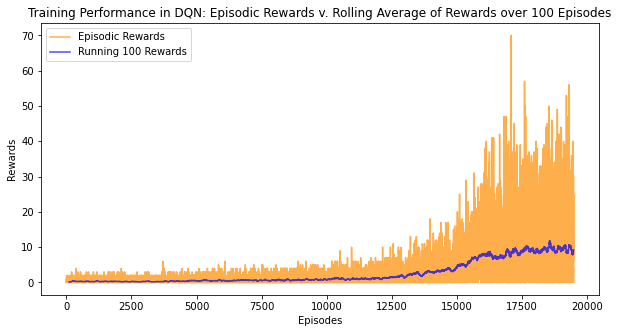

Episodic Rewards       70.00
Running 100 Rewards    11.88
dtype: float64


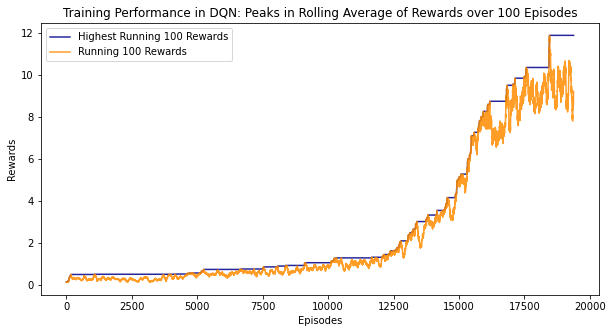

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

rewards = np.load(file='./h5_weights/all_episode_rewards.npy')

rewards = pd.Series(data=rewards)
running_rewards100 = rewards.rolling(window=100).mean().dropna()

episodic_rewards_running_reward = pd.concat([rewards, running_rewards100], axis=1)
episodic_rewards_running_reward.columns = ["Episodic Rewards", "Running 100 Rewards"]
running_rewards100 = running_rewards100.reset_index(drop='index')

ax = episodic_rewards_running_reward.plot(figsize=(10,5), legend=True, alpha=0.70, color=["darkorange","blue"])
ax.set_xlabel("Episodes")
ax.set_ylabel("Rewards")
ax.set_title("Training Performance in DQN: Episodic Rewards v. Rolling Average of Rewards over 100 Episodes")
plt.show()

print(episodic_rewards_running_reward.max())


hi_running_rewards = [running_rewards100.loc[0]]
for i in range(1, len(running_rewards100)):
    if running_rewards100[i] >= hi_running_rewards[-1]:
        hi_running_rewards.append(running_rewards100.loc[i])
    else:
        hi_running_rewards.append(hi_running_rewards[-1])

hi_running_rewards = pd.concat([pd.Series(hi_running_rewards), running_rewards100], axis=1)
hi_running_rewards.columns = ["Highest Running 100 Rewards", "Running 100 Rewards"]
ax = hi_running_rewards.plot(figsize=(10,5), legend=True, alpha=0.85, color=["darkblue","darkorange"])
ax.set_xlabel("Episodes")
ax.set_ylabel("Rewards")
ax.set_title("Training Performance in DQN: Peaks in Rolling Average of Rewards over 100 Episodes")
plt.show()

### Adapted from https://keras.io/examples/rl/deep_q_network_breakout/

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/P20/DQN/h5_weights/

Mounted at /content/drive/
/content/drive/MyDrive/dqn/h5_weights


In [ ]:
!pip install baselines --no-deps --user

from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
%tensorflow_version 2.x
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
with tf.device('/device:GPU:0'):
    # Configuration paramaters for the whole setup
    seed = 42
    gamma = 0.99  # Discount factor for past rewards
    epsilon = 1.0  # Epsilon greedy parameter
    epsilon_min = 0.1  # Minimum epsilon greedy parameter
    epsilon_max = 1.0  # Maximum epsilon greedy parameter
    epsilon_interval = (
        epsilon_max - epsilon_min
    )  # Rate at which to reduce chance of random action being taken
    batch_size = 32  # Size of batch taken from replay buffer
    max_steps_per_episode = 10000

    # Use the Baseline Atari environment because of Deepmind helper functions
    env = make_atari("BreakoutNoFrameskip-v4")
    # Warp the frames, grey scale, stake four frame and scale to smaller ratio
    env = wrap_deepmind(env, frame_stack=True, scale=True)
    env.seed(seed)


    num_actions = 4
    def create_q_model():
        # Network defined by the Deepmind paper
        inputs = layers.Input(shape=(84, 84, 4,))

        # Convolutions on the frames on the screen
        layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
        layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
        layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

        layer4 = layers.Flatten()(layer3)

        layer5 = layers.Dense(512, activation="relu")(layer4)
        action = layers.Dense(num_actions, activation="linear")(layer5)

        return keras.Model(inputs=inputs, outputs=action)


    # The first model makes the predictions for Q-values which are used to
    # make a action.
    model = create_q_model()
    # Build a target model for the prediction of future rewards.
    # The weights of a target model get updated every 10000 steps thus when the
    # loss between the Q-values is calculated the target Q-value is stable.
    model_target = create_q_model()

    # In the Deepmind paper they use RMSProp however then Adam optimizer
    # improves training time
    optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

    # Experience replay buffers
    action_history = []
    state_history = []
    state_next_history = []
    rewards_history = []
    done_history = []
    episode_reward_history = []
    all_episode_rewards = []
    running_reward = 0
    episode_count = 0
    frame_count = 0
    # Number of frames to take random action and observe output
    epsilon_random_frames = 50000
    # Number of frames for exploration
    epsilon_greedy_frames = 1000000.0
    # Maximum replay length
    # Note: The Deepmind paper suggests 1000000 however this causes memory issues
    # max_memory_length = 100000
    max_memory_length = 10000
    # Train the model after 4 actions
    update_after_actions = 4
    # How often to update the target network
    update_target_network = 10000
    # Using huber loss for stability
    loss_function = keras.losses.Huber()

    while True:  # Run until solved
        state = np.array(env.reset())
        episode_reward = 0

        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.
            frame_count += 1

            # Use epsilon-greedy for exploration
            if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
                # Take random action
                action = np.random.choice(num_actions)
            else:
                # Predict action Q-values
                # From environment state
                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = model(state_tensor, training=False)
                # Take best action
                action = tf.argmax(action_probs[0]).numpy()

            # Decay probability of taking random action
            epsilon -= epsilon_interval / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min)

            # Apply the sampled action in our environment
            state_next, reward, done, _ = env.step(action)
            state_next = np.array(state_next)

            episode_reward += reward

            # Save actions and states in replay buffer
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

            # Update every fourth frame and once batch size is over 32
            if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

                # Get indices of samples for replay buffers
                indices = np.random.choice(range(len(done_history)), size=batch_size)

                # Using list comprehension to sample from replay buffer
                state_sample = np.array([state_history[i] for i in indices])
                state_next_sample = np.array([state_next_history[i] for i in indices])
                rewards_sample = [rewards_history[i] for i in indices]
                action_sample = [action_history[i] for i in indices]
                done_sample = tf.convert_to_tensor(
                    [float(done_history[i]) for i in indices]
                )

                # Build the updated Q-values for the sampled future states
                # Use the target model for stability
                future_rewards = model_target.predict(state_next_sample)
                # Q value = reward + discount factor * expected future reward
                updated_q_values = rewards_sample + gamma * tf.reduce_max(
                    future_rewards, axis=1
                )

                # If final frame set the last value to -1
                updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                # Create a mask so we only calculate loss on the updated Q-values
                masks = tf.one_hot(action_sample, num_actions)

                with tf.GradientTape() as tape:
                    # Train the model on the states and updated Q-values
                    q_values = model(state_sample)

                    # Apply the masks to the Q-values to get the Q-value for action taken
                    q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                    # Calculate loss between new Q-value and old Q-value
                    loss = loss_function(updated_q_values, q_action)

                # Backpropagation
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if frame_count % update_target_network == 0:
                # update the the target network with new weights
                model_target.set_weights(model.get_weights())
                # Log details
                template = "running reward: {:.2f} at episode {}, frame count {}"
                print(template.format(running_reward, episode_count, frame_count))

            # Limit the state and reward history
            if len(rewards_history) > max_memory_length:
                del rewards_history[:1]
                del state_history[:1]
                del state_next_history[:1]
                del action_history[:1]
                del done_history[:1]

            if done:
                break

        # Update running reward to check condition for solving
        all_episode_rewards.append(episode_reward)
        episode_reward_history.append(episode_reward)
        if len(episode_reward_history) > 100:
            del episode_reward_history[:1]
        running_reward = np.mean(episode_reward_history)

        episode_count += 1
        if len(episode_reward_history) == 100:
            print(f"\t{episode_count} done \tEpisode Score: {episode_reward}"
                    f"\tRolling Average Score 100 Episodes: {running_reward} \tFrames: {frame_count}")
        else:
            print(f"\t{episode_count} done \tEpisode Score: {episode_reward} \tFrames: {frame_count}")

        if (episode_count) % 50 == 0:
            model.save_weights("keras-model_breakout.h5")
            model_target.save_weights("keras-target_breakout.h5")
            np.save('all_episode_rewards.npy', all_episode_rewards)
        if running_reward > 40 or frame_count >=2000000:  # Condition to consider the task solved
            print("Solved at episode {}!".format(episode_count))
            model.save_weights("keras-model_breakout.h5")
            model_target.save_weights("keras-target_breakout.h5")
            np.save('all_episode_rewards.npy', all_episode_rewards)
            break


Streaming output truncated to the last 5000 lines.
	14599 done 	Episode Score: 2.0	Rolling Average Score 100 Episodes: 3.77 	Frames: 807392
	14600 done 	Episode Score: 0.0	Rolling Average Score 100 Episodes: 3.72 	Frames: 807415
	14601 done 	Episode Score: 8.0	Rolling Average Score 100 Episodes: 3.72 	Frames: 807708
	14602 done 	Episode Score: 1.0	Rolling Average Score 100 Episodes: 3.72 	Frames: 807759
	14603 done 	Episode Score: 13.0	Rolling Average Score 100 Episodes: 3.83 	Frames: 808219
	14604 done 	Episode Score: 4.0	Rolling Average Score 100 Episodes: 3.85 	Frames: 808329
	14605 done 	Episode Score: 1.0	Rolling Average Score 100 Episodes: 3.86 	Frames: 808401
	14606 done 	Episode Score: 2.0	Rolling Average Score 100 Episodes: 3.79 	Frames: 808488
	14607 done 	Episode Score: 3.0	Rolling Average Score 100 Episodes: 3.74 	Frames: 808636
	14608 done 	Episode Score: 0.0	Rolling Average Score 100 Episodes: 3.68 	Frames: 808659
	14609 done 	Episode Score: 5.0	Rolling Average Score 100 